In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ebmdatalab import bq, maps, charts
import matplotlib.gridspec as gridspec

In [2]:
sql= '''
SELECT
month,
  pct,
  register_size AS dementia_register,
  SUM(items) AS items,
  SUM(actual_cost) AS cost
FROM
  ebmdatalab.hscic.normalised_prescribing_standard AS presc
INNER JOIN
  ebmdatalab.hscic.qof_ccgs_1415 AS ccg ##1415 register - update if we do anything with it
ON
  presc.pct = ccg.ccg_code
WHERE
  (bnf_code LIKE "0409010M%" OR ##Memantine
    bnf_code LIKE "0411000D0%" OR ##Donepezil
    bnf_code LIKE "0411000F0%" OR  ##Galantamine
    bnf_code LIKE "0411000E0%")
    AND ccg.indicator_code = "DEM"
   GROUP BY
   month,
   pct,
   register_size
 '''

df_dementia = bq.cached_read(sql, csv_path='dementia.csv')
df_dementia.head(10)

,month,pct,dementia_register,items,cost
0,2010-10-01,00C,1021,665,26670.66000
1,2018-11-01,00C,1021,786,4729.43696
2,2016-02-01,00C,1021,886,4927.32000
3,2013-02-01,00C,1021,703,7829.17000
4,2010-09-01,00C,1021,678,26955.64000
5,2018-12-01,00C,1021,820,4637.32320
6,2011-09-01,00C,1021,743,29758.22000
7,2013-10-01,00C,1021,828,7709.09000
8,2018-10-01,00C,1021,881,5363.48552
9,2015-11-01,00C,1021,741,4581.05000


In [3]:
df_dementia['item per dem patient'] = df_dementia['items'] / df_dementia['dementia_register']
df_dementia.head(5)

,month,pct,dementia_register,items,cost,item per dem patient
0,2010-10-01,00C,1021,665,26670.66000,0.651322
1,2018-11-01,00C,1021,786,4729.43696,0.769833
2,2016-02-01,00C,1021,886,4927.32000,0.867777
3,2013-02-01,00C,1021,703,7829.17000,0.688541
4,2010-09-01,00C,1021,678,26955.64000,0.664055


In [4]:
# filter for ccg and not pct
ccg_dem = df_dementia.copy().loc[(df_dementia["month"]>"2013-03-01") ] 
ccg_dem.head(5)

x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))

#filtered tables grouped by months
pcf = ccg_dem.groupby('month').quantile(x)

#putting groupby(month) from index back into being a column
pcf = pcf.reset_index().rename(columns={"level_1": 'percentile'})
pcf.head(10)

,month,percentile,dementia_register,items,cost,item per dem patient
0,2013-04-01,0.10,998.90,159.50,2494.2600,0.099101
1,2013-04-01,0.20,1155.00,318.80,4650.8360,0.247190
2,2013-04-01,0.30,1401.30,437.10,6299.9600,0.309086
3,2013-04-01,0.40,1550.80,541.00,7566.3160,0.350751
4,2013-04-01,0.50,1740.00,625.00,9066.4150,0.381556
5,2013-04-01,0.60,1910.00,763.20,10735.5740,0.407826
6,2013-04-01,0.70,2205.30,906.60,13462.8660,0.464606
7,2013-04-01,0.80,2658.20,1155.60,19675.3960,0.539173
8,2013-04-01,0.90,3380.50,1412.50,27457.5440,0.635261
9,2013-04-01,0.01,685.64,26.35,699.1207,0.017767


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


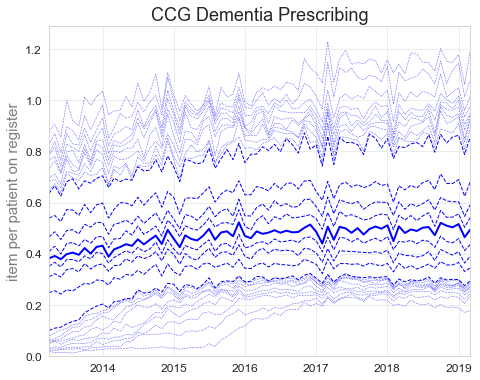

In [5]:
import seaborn as sns
import datetime
sns.set_style("whitegrid",{'grid.color': '.9'})
dfp = pcf.sort_values(by=["month"])#,"drug"])
dfp['month'] = dfp['month'].astype(str)
# set format for dates:
dfp['dates'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in dfp['month']]

# set sort order of drugs manually, and add grid refs to position each subplot:
# order is column, title, axis
s = [(0,'item per dem patient',0,0,'CCG Dementia Prescribing','item per patient on register'), ]


x = pd.Series(x)
fig = plt.figure(figsize=(16,20)) 
gs = gridspec.GridSpec(3,2)  # grid layout for subplots

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    for decile in x:   # plot each decile line
        data = dfp.loc[(dfp['percentile']==decile)]#(dfp['drug']==i[1]) & 
        if decile == .5:
            ax.plot(data["dates"],data[i[1]],'b-',linewidth=2)
        elif (decile <0.1) | (decile >0.9):
            ax.plot(data["dates"],data[i[1]],'b:',linewidth=0.6)
        else:
            ax.plot(data["dates"],data[i[1]],'b--',linewidth=1)
    ax.set_ylabel(i[5], size =15, alpha=0.6)
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, dfp[i[1]].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([dfp['dates'].min(), dfp['dates'].max()]) # set x axis range as full date range

plt.subplots_adjust(wspace = 0.12,hspace = 0.15)
plt.savefig('ccg_deciles_no_smooth.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

In [6]:
df_dem_18 = df_dementia.loc[(df_dementia["month"]>="2018-01-01") & (df_dementia["month"]<="2018-01-01")]
df_dem_18.head()

,month,pct,dementia_register,items,cost,item per dem patient
83,2018-01-01,00C,1021,876,4799.78663,0.857982
131,2018-01-01,00D,2809,1744,10901.13821,0.620862
248,2018-01-01,00J,1997,1910,11405.45657,0.956435
372,2018-01-01,00K,2784,1327,14933.09383,0.476652
439,2018-01-01,00L,2976,2010,12006.99144,0.675403


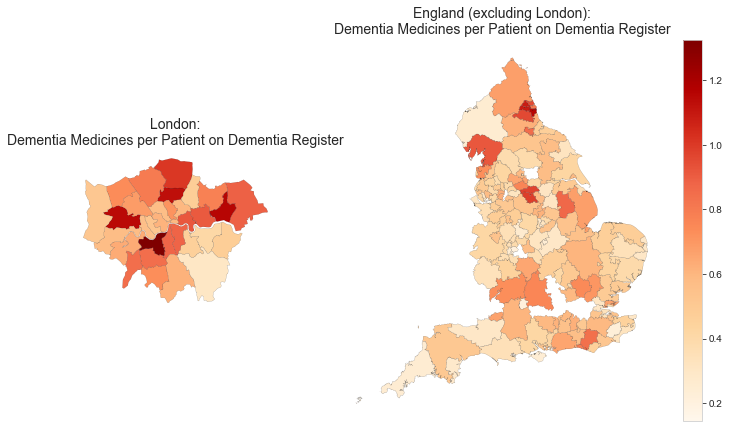

In [7]:
plt.figure(figsize=(12, 7))
maps.ccg_map(df_dem_18, title="Dementia Medicines per Patient on Dementia Register", column='item per dem patient', 
             separate_london=True)
plt.savefig('map.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

what are the blanks on the map? Is it an error or really low prescribing? 

In [8]:
df_dem_18.isnull().any() ##checking to see if any NaN values

month                   False
pct                     False
dementia_register       False
items                   False
cost                    False
item per dem patient    False
dtype: bool

In [9]:
##identify CCGs with low rates that may look white on scale
less_zero = df_dem_18.loc[(df_dementia['item per dem patient'] <0.2)]
less_zero.head()

,month,pct,dementia_register,items,cost,item per dem patient
1884,2018-01-01,01F,893,130,1053.93129,0.145577


Ask Seb, maybe an issue with pandas datalab. Looks like Leeds/Wakefield implicated